## Working theory - weighted combinations of arrival time and cost in MCDM do not account for true expected outcomes 




## Configuration

##### Import Packages

In [1]:
import collections
import datetime
import itertools
import matplotlib.pyplot as plt
import mcdm
import numpy as np
import pandas as pd
import random
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

##### Out of Network Cost & ETA Assumptions

In [2]:
oon_cost = 250
oon_eta = 0.05

## Define Functions & Classes

In [3]:
def normalize_to_median(iterable):
    """
    Normalize using (Xi - MEDIAN(X)) / STDEV(X) rather than the conventional mean
    Args:
        iterable: some iterable object with floats
    Returns:
        (normalized) iterable
    """
    median_x = np.median(iterable)
    stdev_x = np.std(iterable)
    return [(x - median_x) / stdev_x for x in iterable]


def min_max_normalize(iterable):
    """
    Normalize using (Xi - MEDIAN(X)) / STDEV(X) rather than the conventional mean
    Args:
        iterable: some iterable object with floats
    Returns:
        (normalized) iterable
    """
    return [(x - min(iterable)) / (max(iterable) - min(iterable)) for x in iterable]


def print_timestamp_message(message, timestamp_format = '%Y-%m-%d %H:%M:%S'):
    """
    Print formatted timestamp followed by custom message
    Args:
        message (str): string to concatenate with timestamp
        timestamp_format (str): format for datetime string. defaults to '%Y-%m-%d %H:%M:%S'
    """
    ts_string = datetime.datetime.fromtimestamp(time.time()).strftime(timestamp_format)
    print(f'{ts_string}: {message}')
    

class SimulatedSuppliers:
    def __init__(self,
                 n_suppliers,
                 accept_plot_attribs = {'x_label' : 'Boost Dollars',
                                        'y_label' : 'Acceptance Probability',
                                        'marker' : 'o'},
                 base_cost_range = [80, 130],
                 boost_values = list(range(0,50,5)),
                 mean_acceptance = 0.55,
                 stdev_acceptance = 0.1,
                 random_seed = 832021):
        """
        Simulate supplier data with cost, eta service level probability, and acceptance probabilities
        given specified ranges
        
        Example:
            supplier_simulation = SimulatedSuppliers(supplier_names = [f'Supplier {n}' for n in range(1,4)])
            supplier_simulation_df = supplier_simulation.generate_supplier_info() 
        """
        self.n_suppliers = n_suppliers
        self.accept_plot_attribs = accept_plot_attribs
        self.base_cost_range = base_cost_range
        self.boost_values = boost_values
        self.mean_acceptance = mean_acceptance
        self.stdev_acceptance = stdev_acceptance
        self.random_seed = random_seed
        
        
    def get_random_boost_probs(self):
        """
        Generate random acceptance probabilities given a range of boost values
        that follow a 2nd order polynomial pattern
        Args:
            boost_values (list): list of dollar values used in boost
            mean_acceptance (float): average acceptance rate at $0 boost
            stdev_acceptance (float): standard deviation of acceptance rate at $0 boost
            supplier_name (str): name of simulated supplier
        Returns:
            pandas.DataFrame object with fields 'boost_dollars', 'accept_prob', and 'supplier'
        """
        np.random.seed(self.random_seed)
        random.seed(self.random_seed)
        supplier_names = [f'Supplier {n}' for n in range(1, (self.n_suppliers + 1))]
        boost_df_list = []
        for sn in supplier_names:
            acceptance_distr = np.random.normal(self.mean_acceptance, self.stdev_acceptance, 1000)
            b0 = random.choice([x for x in acceptance_distr if (x > 0) and (x < 1)])
            max_b1 = ((1 - b0) / max(self.boost_values))
            b1 = random.choice(np.linspace(0, max_b1, 100))
            max_b2 = (1 - (b0 + (b1 * max(self.boost_values)))) / max(self.boost_values)**2
            b2 = random.choice(np.linspace(0, max_b2, 100))
            probs = []
            for x in self.boost_values:
                p = b0 + (b1 * x) + (b2 * x**2)
                probs.append(p)
            boost_df = pd.DataFrame({'boost_dollars' : self.boost_values, 'accept_prob' : probs})
            boost_df['supplier'] = sn
            boost_df_list.append(boost_df)
        output_df = pd.concat(boost_df_list, axis = 0)
        return output_df
    
    
    def generate_supplier_info(self):
        """
        Generate a pandas.DataFrame object with costs in a given range and eta probabilities
        0 to 1 representing the likelihood of completing service in under 45 minutes
        Args:
            supplier_names (list): list of supplier names
            base_cost_range (list): minimum and maximum baseline cost for each supplier
        Returns:
            pandas.DataFrame object with fields 'supplier', 'base_cost', 'eta_prob' which
            is merged with the output of get_random_boost_probs()
        """
        random.seed(self.random_seed)
        supplier_names = [f'Supplier {n}' for n in range(1, (self.n_suppliers + 1))]
        boost_prob_df = self.get_random_boost_probs()
        eta_probs = [random.choice(np.linspace(0,1,100)) for i in range(len(supplier_names))]
        base_cost = [random.choice(np.linspace(self.base_cost_range[0], self.base_cost_range[1], 100)) for i in range(len(supplier_names))]
        supplier_info_df = pd.DataFrame({'supplier' : supplier_names, 'base_cost' : base_cost, 'eta_prob' : eta_probs})
        supplier_boost_info_df = pd.merge(supplier_info_df, boost_prob_df, on = 'supplier', how = 'left')
        supplier_boost_info_df['total_cost'] = supplier_boost_info_df['base_cost'] + supplier_boost_info_df['boost_dollars']
        supplier_boost_info_df['eta_per_dollar'] = supplier_boost_info_df['eta_prob'] / supplier_boost_info_df['total_cost']
        return supplier_boost_info_df
        
    
    def plot_supplier_acceptance(self):
        """
        Plot curves of acceptance probability for each supplier based on boost dollars
        offered using the output of the generate_supplier_info() attribute
        Args:
            accept_plot_attribs (dict): dictionary with plot attributes defined
            by keys 'x_label', 'y_label', and 'marker'
        Returns:
            None
        """
        sup_df = self.generate_supplier_info()
        sns.lineplot(x = 'boost_dollars',
                     y = 'accept_prob',
                     hue = 'supplier',
                     marker = self.accept_plot_attribs.get('marker'),  data = sup_df)
        plt.ylabel(self.accept_plot_attribs.get('y_label'))
        plt.xlabel(self.accept_plot_attribs.get('x_label'))
        plt.show()
        

def calc_exp_network_result(dframe, total_cost, eta_prob, accept_prob, sort_order = None, sort_col = None):
    """
    Given a rank-ordered list of suppliers (and their cost, acceptance probabilities,
    ata probabilities) calculate the expected cost and ata of 
    providing sequential offers
    Args:
        dframe (pandas.DataFrame): input DataFrame object
        total_cost (string): column name representing total cost of each supplier
        eta_prob (string): column name representing the probability of ETA falling below service level
        accept_prob (string):  column name with floats representing acceptance likelihood of each supplier
        sort_order (list): list with customized sorting to be applied to <sort_col>. defaults to None.
        sort_col (string): column name with values to be sorted according to <sort_order>. defaults to None.
    Returns:
        dframe_copy (pandas.DataFrame): pandas.DataFrame with additional columns 'selection_prob', 'expected_cost', 'expected_eta_prob'
        agg_exp_cost (float): float representing expected cost from providing sequential offers
        agg_exp_eta_prob (float): float representing expected eta probability from providing sequential offers
        oon_prob (float): probability of offer going out of network (inverse of cumulative acceptance probability)
    """
    # Copy dataframe and apply custom sorting
    dframe_copy = dframe.copy()
    if sort_order is not None:
        sort_dict = dict(zip(sort_order, range(len(sort_order))))
        dframe_copy['sort_value'] = dframe_copy[sort_col].map(sort_dict)
        dframe_copy = dframe_copy.sort_values('sort_value')
        dframe_copy.drop('sort_value', axis = 1, inplace = True)
    
    # Probabilities of each supplier being accepted given sequential order and acceptance probabilities
    selection_prob = []
    for i, ap in enumerate(dframe[accept_prob]):
        if i == 0:
            selection_prob.append(ap)
        else:
            selection_prob.append((1 - sum(selection_prob)) * ap)
    
    # Expected cost, eta probability, out of network probability
    agg_exp_cost = np.dot(selection_prob, dframe_copy[total_cost])
    agg_exp_eta_prob = np.dot(selection_prob, dframe_copy[eta_prob])
    dframe_copy['selection_prob'] = selection_prob
    dframe_copy['expected_cost'] = dframe_copy['selection_prob'] * dframe_copy[total_cost]
    dframe_copy['expected_eta_prob'] = dframe_copy['selection_prob'] * dframe_copy[eta_prob]
    oon_prob = 1 - sum(selection_prob)
    
    return dframe_copy, agg_exp_cost, agg_exp_eta_prob, oon_prob


## Execution

##### Create & Visualize Simulated Supplier Data

In [4]:
supplier_simulation = SimulatedSuppliers(n_suppliers = 7, random_seed = 29)
supplier_simulation_df = supplier_simulation.generate_supplier_info()    
supplier_simulation_df.head()

,supplier,base_cost,eta_prob,boost_dollars,accept_prob,total_cost,eta_per_dollar
0,Supplier 1,108.787879,0.636364,0,0.551700,108.787879,0.005850
1,Supplier 1,108.787879,0.636364,5,0.558465,113.787879,0.005593
2,Supplier 1,108.787879,0.636364,10,0.569701,118.787879,0.005357
3,Supplier 1,108.787879,0.636364,15,0.585411,123.787879,0.005141
4,Supplier 1,108.787879,0.636364,20,0.605592,128.787879,0.004941


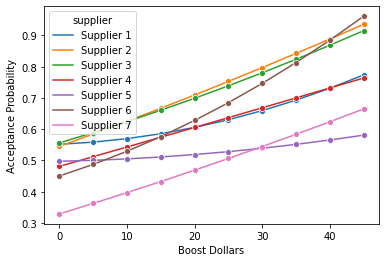

In [5]:
supplier_simulation.plot_supplier_acceptance()

##### Demonstrate expected outcome on $0 boosts (leave order of suppliers as is for now)

In [6]:
temp = supplier_simulation_df[supplier_simulation_df.boost_dollars == 0]
supplier_outcome_df, exp_cost, exp_eta_prob, oon_prob = calc_exp_network_result(dframe = temp, total_cost = 'total_cost',
                                                                                eta_prob = 'eta_prob', accept_prob = 'accept_prob',
                                                                                sort_order = None, sort_col = None)

In [7]:
supplier_outcome_df

,supplier,base_cost,eta_prob,boost_dollars,accept_prob,total_cost,eta_per_dollar,selection_prob,expected_cost,expected_eta_prob
0,Supplier 1,108.787879,0.636364,0,0.551700,108.787879,0.005850,0.551700,60.018283,0.351082
10,Supplier 2,90.606061,0.424242,0,0.544770,90.606061,0.004682,0.244221,22.127860,0.103609
20,Supplier 3,94.141414,0.777778,0,0.555890,94.141414,0.008262,0.113446,10.679935,0.088236
30,Supplier 4,107.777778,0.696970,0,0.481029,107.777778,0.006467,0.043597,4.698833,0.030386
40,Supplier 5,106.262626,0.535354,0,0.497263,106.262626,0.005038,0.023389,2.485418,0.012522
50,Supplier 6,123.434343,0.939394,0,0.450171,123.434343,0.007610,0.010645,1.313978,0.010000
60,Supplier 7,123.939394,0.252525,0,0.328837,123.939394,0.002037,0.004275,0.529897,0.001080


##### Notice 'selection_prob' above. This value is used to capture the sequential, interdependent acceptance probability

##### Expected Cost (dot product of (sequential) acceptance likelihood and supplier cost)

In [8]:
print(f'Expected cost if offers made in above sequence: ${np.round(exp_cost,2)}')

Expected cost if offers made in above sequence: $101.85


##### Expected ETA Probability (dot product of (sequential) acceptance likelihood and supplier eta)

In [9]:
print(f'Expected eta probability if offers made in above sequence: {np.round(exp_eta_prob*100,2)}%')

Expected eta probability if offers made in above sequence: 59.69%


##### Compare Every Possible Order of Suppliers (assuming some higher out of network cost and ETA)

In [10]:
possible_rank_orders = itertools.permutations(temp['supplier'])
supplier_order_list = []
exp_cost_list = []
exp_eta_list = []

for i, pro in enumerate(possible_rank_orders):
    supplier_outcome_df, exp_cost, exp_eta_prob, oon_prob = calc_exp_network_result(dframe = temp, total_cost = 'total_cost',
                                                                                    eta_prob = 'eta_prob', accept_prob = 'accept_prob',
                                                                                    sort_order = list(pro), sort_col = 'supplier')
    supplier_order_list.append(', '.join(list(pro)))
    
    exp_cost_list.append((exp_cost * (1 - oon_prob)) + (oon_cost * oon_prob))
    exp_eta_list.append((exp_eta_prob * (1 - oon_prob) + (oon_eta * oon_prob)))
    if i % 250 == 0:
        print_timestamp_message(f'Completed {i+1} iterations')

2021-08-03 16:31:55: Completed 1 iterations
2021-08-03 16:31:56: Completed 251 iterations
2021-08-03 16:31:56: Completed 501 iterations
2021-08-03 16:31:57: Completed 751 iterations
2021-08-03 16:31:58: Completed 1001 iterations
2021-08-03 16:31:58: Completed 1251 iterations
2021-08-03 16:31:59: Completed 1501 iterations
2021-08-03 16:32:00: Completed 1751 iterations
2021-08-03 16:32:00: Completed 2001 iterations
2021-08-03 16:32:01: Completed 2251 iterations
2021-08-03 16:32:02: Completed 2501 iterations
2021-08-03 16:32:03: Completed 2751 iterations
2021-08-03 16:32:03: Completed 3001 iterations
2021-08-03 16:32:04: Completed 3251 iterations
2021-08-03 16:32:05: Completed 3501 iterations
2021-08-03 16:32:05: Completed 3751 iterations
2021-08-03 16:32:06: Completed 4001 iterations
2021-08-03 16:32:07: Completed 4251 iterations
2021-08-03 16:32:07: Completed 4501 iterations
2021-08-03 16:32:08: Completed 4751 iterations
2021-08-03 16:32:09: Completed 5001 iterations


## Aggregate & Visualize Results

##### Aggregation

In [11]:
rank_order_outcomes = pd.DataFrame({'supplier_order' : supplier_order_list,
                                    'expected_cost' : exp_cost_list,
                                    'eta_prob' : exp_eta_list})

rank_order_outcomes['expected_cost_norm'] = min_max_normalize(rank_order_outcomes['expected_cost'])
rank_order_outcomes['eta_prob_norm'] = min_max_normalize(rank_order_outcomes['eta_prob'])
rank_order_outcomes['eta_norm_less_cost_norm'] = rank_order_outcomes['eta_prob_norm'] - rank_order_outcomes['expected_cost_norm']
best_outcome_df = rank_order_outcomes[rank_order_outcomes['eta_norm_less_cost_norm'] == max(rank_order_outcomes['eta_norm_less_cost_norm'])]
rank_order_outcomes['best_outcome'] = ['Yes' if x == best_outcome_df['supplier_order'].iloc[0] else 'No' for x in rank_order_outcomes['supplier_order']]

##### Optimal Outcome

In [12]:
best_result_df, exp_cost, exp_eta_prob, oon_prob = calc_exp_network_result(dframe = temp, total_cost = 'total_cost',
                                                                           eta_prob = 'eta_prob', accept_prob = 'accept_prob',
                                                                           sort_order = best_outcome_df['supplier_order'].iloc[0].split(', '),
                                                                           sort_col = 'supplier')

In [13]:
print(f'Expected cost if offers made in above sequence: ${np.round(exp_cost,2)}')

Expected cost if offers made in above sequence: $95.88


In [14]:
print(f'Expected eta probability if offers made in above sequence: {np.round(exp_eta_prob*100,2)}%')

Expected eta probability if offers made in above sequence: 67.44%


##### Visualize Normalized Points

Text(0.5, 1.0, 'ETA : Cost Ratio Expectations')

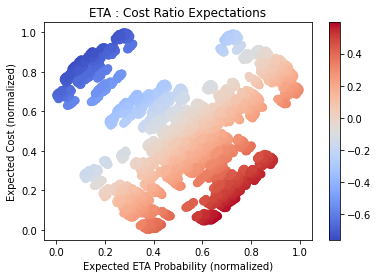

In [15]:
cmap = sns.color_palette("coolwarm", as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(rank_order_outcomes['eta_prob_norm'], rank_order_outcomes['expected_cost_norm'],
                    c = rank_order_outcomes['eta_norm_less_cost_norm'], s=50, cmap=cmap)
f.colorbar(points)
plt.ylabel('Expected Cost (normalized)')
plt.xlabel('Expected ETA Probability (normalized)')
plt.title('ETA : Cost Ratio Expectations')

##### Visualize Actual Points

Text(0.5, 1.0, 'ETA : Cost Ratio Expectations')

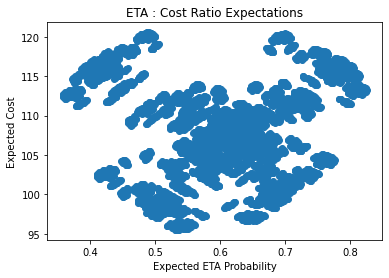

In [16]:
f, ax = plt.subplots()
points = ax.scatter(rank_order_outcomes['eta_prob'], rank_order_outcomes['expected_cost'])
plt.ylabel('Expected Cost')
plt.xlabel('Expected ETA Probability')
plt.title('ETA : Cost Ratio Expectations')

##### Visualize 'Optimal' Point (assumes maximum {Normalized ETA - Normalized Cost} is ideal)

Text(0.5, 1.0, 'Optimal Point in Green')

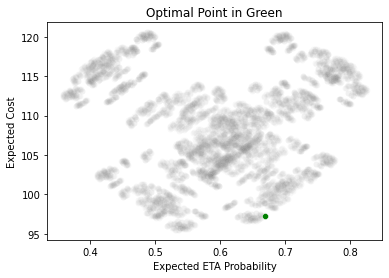

In [17]:
f, ax = plt.subplots()
sns.scatterplot('eta_prob', 'expected_cost', color = 'grey', data = rank_order_outcomes[rank_order_outcomes.best_outcome == 'No'], alpha=0.05)
sns.scatterplot('eta_prob', 'expected_cost', color = 'green', data = rank_order_outcomes[rank_order_outcomes.best_outcome == 'Yes'])
plt.ylabel('Expected Cost')
plt.xlabel('Expected ETA Probability')
plt.title('Optimal Point in Green')

## TO DO: Test Incremental Boosts to Improve Ratio

## TO DO: Compare Above Method to MCDM